Analysiere Log-Datei: training_log_20241217_011452.json
JSON-Fehler in Zeile 1: Expecting property name enclosed in double quotes: line 1 column 2 (char 1)
JSON-Fehler in Zeile 2: Extra data: line 1 column 18 (char 17)
JSON-Fehler in Zeile 3: Extra data: line 1 column 13 (char 12)
JSON-Fehler in Zeile 4: Extra data: line 1 column 12 (char 11)
JSON-Fehler in Zeile 5: Extra data: line 1 column 7 (char 6)
JSON-Fehler in Zeile 6: Extra data: line 1 column 10 (char 9)
JSON-Fehler in Zeile 7: Extra data: line 1 column 12 (char 11)
JSON-Fehler in Zeile 8: Extra data: line 1 column 15 (char 14)
JSON-Fehler in Zeile 9: Extra data: line 1 column 12 (char 11)
JSON-Fehler in Zeile 10: Extra data: line 1 column 10 (char 9)
JSON-Fehler in Zeile 11: Extra data: line 1 column 8 (char 7)
JSON-Fehler in Zeile 12: Extra data: line 1 column 18 (char 17)
JSON-Fehler in Zeile 13: Extra data: line 1 column 10 (char 9)
JSON-Fehler in Zeile 14: Extra data: line 1 column 8 (char 7)
JSON-Fehler in Zeile 15: Extr

TypeError: ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

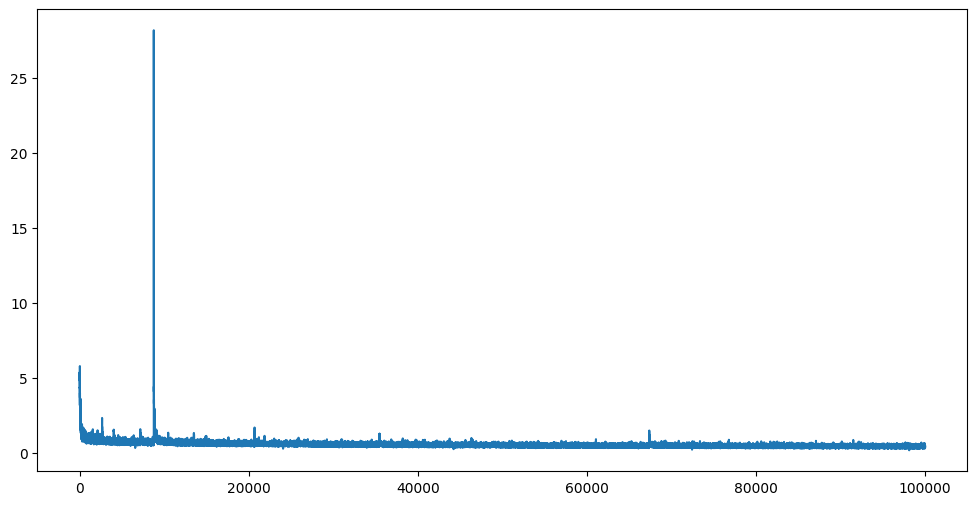

In [25]:
import json
import matplotlib.pyplot as plt
import numpy as np
import os
from datetime import datetime

# Konfiguration für bessere Plot-Darstellung
%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 6]

# Absoluter Pfad zu den Log-Dateien
LOG_DIR = r"E:\Schallsimulationsdaten\urban_sound_25k_reflection\newtrainingsparameterCheckpoints\soundmap\512x512\glow_improved\building2soundmap\logs"

# Prüfe ob Verzeichnis existiert
if not os.path.exists(LOG_DIR):
    raise ValueError(f"Log-Verzeichnis existiert nicht: {LOG_DIR}")

# Lade die neueste Log-Datei
log_files = [f for f in os.listdir(LOG_DIR) if f.startswith('training_log_')]
log_files.sort(reverse=True)
if not log_files:
    raise ValueError(f"Keine Log-Dateien gefunden in {LOG_DIR}")
log_file = log_files[0]
log_path = os.path.join(LOG_DIR, log_file)

print(f"Analysiere Log-Datei: {log_file}")

# Initialisiere Metrics Dictionary
metrics = {
    'iteration': [],
    'train_loss': [],
    'val_loss': [],
    'loss_left': [],
    'loss_right': [],
    'learning_rate': [],
    'time': [],
    'memory': []
}

# Debug-Zähler
parsed_lines = 0
error_lines = 0

# Log-Datei zeilenweise einlesen und parsen
with open(log_path, 'r') as f:
    for line_num, line in enumerate(f, 1):
        try:
            # Überspringe leere Zeilen
            if not line.strip():
                continue
                
            data = json.loads(line.strip())
            
            # Überprüfe ob data ein Dictionary ist
            if not isinstance(data, dict):
                print(f"Warnung: Zeile {line_num} enthält kein JSON-Objekt")
                continue
                
            if 'hyperparameters' in data:
                hyperparameters = data['hyperparameters']
                parsed_lines += 1
                continue
                
            if 'metrics' not in data:
                print(f"Warnung: Zeile {line_num} enthält keine Metriken")
                continue
                
            # Extrahiere Metriken für jede Iteration
            metrics['iteration'].append(data['iteration'])
            metrics['time'].append(data['time_taken'])
            metrics['memory'].append(data['memory_used'])
            
            # Werte aus dem metrics dict extrahieren
            iter_metrics = data['metrics']
            metrics['train_loss'].append(iter_metrics.get('loss'))
            metrics['val_loss'].append(iter_metrics.get('val_loss'))
            metrics['loss_left'].append(iter_metrics.get('loss_left'))
            metrics['loss_right'].append(iter_metrics.get('loss_right'))
            metrics['learning_rate'].append(iter_metrics.get('learning_rate'))
            
            parsed_lines += 1
            
        except json.JSONDecodeError as e:
            print(f"JSON-Fehler in Zeile {line_num}: {e}")
            error_lines += 1
            continue
        except Exception as e:
            print(f"Unerwarteter Fehler in Zeile {line_num}: {e}")
            print(f"Problematische Zeile: {line.strip()[:100]}...")
            error_lines += 1
            continue

print(f"\nParsing-Statistik:")
print(f"Erfolgreich geparste Zeilen: {parsed_lines}")
print(f"Fehlerhafte Zeilen: {error_lines}")
print(f"Erfasste Iterationen: {len(metrics['iteration'])}")

# Konvertiere zu numpy arrays
for key in metrics:
    metrics[key] = np.array(metrics[key])

print(f"Erfolgreich eingelesene Iterationen: {len(metrics['iteration'])}")

# Zeige Hyperparameter
print("\nHyperparameter:")
print("===============")
for key, value in hyperparameters.items():
    if isinstance(value, dict):
        print(f"\n{key}:")
        for k, v in value.items():
            print(f"  {k}: {v}")
    else:
        print(f"{key}: {value}")

# Plot 1: Training und Validation Loss
plt.figure(figsize=(12, 6))
plt.plot(metrics['iteration'], metrics['train_loss'], label='Training Loss')

# Plot validation loss where available
val_mask = ~np.isnan(metrics['val_loss'])
if np.any(val_mask):
    plt.plot(metrics['iteration'][val_mask], 
            metrics['val_loss'][val_mask], 
            'o-', label='Validation Loss')

plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training und Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot 2: Component Losses (Left/Right)
if not np.all(np.isnan(metrics['loss_left'])):
    plt.figure(figsize=(12, 6))
    plt.plot(metrics['iteration'], metrics['loss_left'], label='Left Loss')
    plt.plot(metrics['iteration'], metrics['loss_right'], label='Right Loss')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.title('Component Losses')
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot 3: Learning Rate
plt.figure(figsize=(12, 6))
plt.plot(metrics['iteration'], metrics['learning_rate'])
plt.xlabel('Iteration')
plt.ylabel('Learning Rate')
plt.title('Learning Rate Schedule')
plt.grid(True)
plt.show()

# Plot 4: Performance Metrics
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

# Iteration time
ax1.plot(metrics['iteration'], metrics['time'])
ax1.set_ylabel('Seconds')
ax1.set_title('Zeit pro Iteration')
ax1.grid(True)

# Memory usage
ax2.plot(metrics['iteration'], metrics['memory'])
ax2.set_xlabel('Iteration')
ax2.set_ylabel('GB')
ax2.set_title('Speichernutzung')
ax2.grid(True)

plt.tight_layout()
plt.show()

# Berechne und zeige Statistiken
stats = {
    'total_iterations': len(metrics['iteration'])
}

# Sichere Berechnung der Statistiken
if len(metrics['time']) > 0:
    stats['total_time'] = np.sum(metrics['time']) / 3600  # in hours
    stats['avg_iteration_time'] = np.mean(metrics['time'])
else:
    stats['total_time'] = 0
    stats['avg_iteration_time'] = 0

if len(metrics['memory']) > 0:
    stats['peak_memory'] = np.max(metrics['memory'])
else:
    stats['peak_memory'] = 0

if len(metrics['train_loss']) > 0:
    stats['final_train_loss'] = metrics['train_loss'][-1]
    stats['best_train_loss'] = np.min(metrics['train_loss'])
else:
    stats['final_train_loss'] = 0
    stats['best_train_loss'] = 0

# Validation Loss nur berechnen wenn vorhanden
val_losses = metrics['val_loss'][~np.isnan(metrics['val_loss'])]
if len(val_losses) > 0:
    stats['best_val_loss'] = np.min(val_losses)

print("\nTraining Statistiken:")
print("===================")
print(f"Gesamtanzahl Iterationen: {stats['total_iterations']}")
print(f"Gesamttrainingszeit: {stats['total_time']:.2f} Stunden")
print(f"Durchschnittliche Zeit pro Iteration: {stats['avg_iteration_time']:.3f} Sekunden")
print(f"Maximale Speichernutzung: {stats['peak_memory']:.2f} GB")
print(f"Finaler Training Loss: {stats['final_train_loss']:.6f}")
print(f"Bester Training Loss: {stats['best_train_loss']:.6f}")
if 'best_val_loss' in stats:
    print(f"Bester Validation Loss: {stats['best_val_loss']:.6f}")

# Optionale Analyse: Loss-Verbesserung über Zeit
if len(metrics['train_loss']) > 1:
    loss_improvements = np.diff(metrics['train_loss'])
    print(f"\nDurchschnittliche Loss-Verbesserung pro Iteration: {-np.mean(loss_improvements):.6f}")
    if len(loss_improvements) >= 1000:
        print(f"Loss-Verbesserung letzte 1000 Iterationen: {-np.mean(loss_improvements[-1000:]):.6f}")

# Debug-Ausgabe
print("\nDebug Information:")
print("=================")
for key, value in metrics.items():
    print(f"{key}: {len(value)} Einträge")
    if len(value) > 0:
        print(f"  Erste 3 Werte: {value[:3]}")